# Recurrent Neural Networks - IMDB Movie Reviews

Based on https://www.tensorflow.org/tutorials/keras/text_classification and https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/.
This notebook loads labeled IMDB review data with the aim to classify sentiment (positive/negative). The original data set is available from http://ai.stanford.edu/~amaas/data/sentiment/.

## Preparations

In [1]:
import os

## adapt this directories to your needs
base_dir = '../../'
data_dir_base = os.path.join(base_dir, "DataSets")
# data_dir_base = r"D:\Users\Julian\OneDrive - FH OOe\Kurse\3. Semester\NDLeIL\Datasets"
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(data_dir_base, 'IMDB_processed')

In [2]:
import os
import re
import string

import numpy as np
import pandas as pd
import tensorflow as tf

from pyMLaux import plot_history, evaluate_classification_result

2024-12-18 20:00:00.591290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 20:00:00.608535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 20:00:00.613464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 20:00:00.625594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_data_dir = os.path.join(data_dir, 'aclImdb/train')
test_data_dir = os.path.join(data_dir, 'aclImdb/test')

## Configure Data Sources

In [4]:
batch_size = 64

train_data_raw = tf.keras.utils.text_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    validation_split=0.15,
    subset='training',
    seed=4232)

validation_data_raw = tf.keras.utils.text_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    validation_split=0.15,
    subset='validation',
    seed=4232)

test_data_raw = tf.keras.utils.text_dataset_from_directory(
    test_data_dir,
    batch_size=batch_size,
    shuffle=False)

Found 2019 files belonging to 1 classes.
Using 1717 files for training.


I0000 00:00:1734552003.068870   18075 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734552003.114272   18075 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734552003.118588   18075 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734552003.122767   18075 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 2019 files belonging to 1 classes.
Using 302 files for validation.
Found 21658 files belonging to 2 classes.


In [5]:
for text_batch, label_batch in train_data_raw:
    for i in range(3):
        print('Review:\n', str(text_batch.numpy()[i]),
              '\nLabel:',  train_data_raw.class_names[label_batch.numpy()[i]], '\n')
    break

Review:
 b"If you enjoy films like American Pie, Road Trip & Van Wilder; avoid this cinematic refuse at all costs. It is an unamusing, mean-spirited, insipid waste of resources that should never have been discussed aloud; much less actually recorded and sold to unsuspecting consumers. Easily the worst film I have seen in the past 18 months; mind-numbingly bad for the entire 86 minutes of it's runtime. Had it been much longer, I would not have been able to write this review without using profanity. Consider yourself warned!" 
Label: neg 

Review:
 b"As much as I love Rodney Dangerfield, this was a terrible movie. The plot was kind of a holistic rip off of various movies, but unfortunately they forgot to rip off any good jokes. In addition it was annoying and boring and that's being kind. If you're looking for a good laugh, rent a copy of Private Parts." 
Label: neg 

Review:
 b"Since Crouching Tiger Hidden Dragon came along, there's been a lot of talk about a revival of the Hong Kong mo

In [6]:
## function for removing HTML tags like <br />
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [7]:
max_features = 10000 ## size of vocabulary
sequence_length = 250 ## standardized length of text sequences

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [8]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_data_raw.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-12-18 20:00:06.109496: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
print(' 123 -> ', vectorize_layer.get_vocabulary()[123])
print('4232 -> ', vectorize_layer.get_vocabulary()[4232])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

 123 ->  thing
4232 ->  frontal
Vocabulary size: 10000


In [10]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [11]:
train_data = train_data_raw.map(vectorize_text)
validation_data = validation_data_raw.map(vectorize_text)
test_data = test_data_raw.map(vectorize_text)

## Create Model

In [12]:
embedding_vector_length = 32
no_lstm_units = 100
epochs = 20

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1, )),
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length),
    tf.keras.layers.LSTM(no_lstm_units),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1, 32)          │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,301 (1.42 MB)

 Trainable params: 373,301 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [15]:
model_path_base = os.path.join(base_dir, 'Models/IMDB_model1')
filepath = os.path.join(model_path_base, 'IMDB_model1_{epoch:02d}-{val_accuracy:.4f}.keras')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_data, validation_data=validation_data, epochs=epochs,
                    batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/20


2024-12-18 20:00:09.224850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8639 - loss: 0.4270
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ../../Models/IMDB_model1/IMDB_model1_01-1.0000.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8712 - loss: 0.4108 - val_accuracy: 1.0000 - val_loss: 3.8337e-04
Epoch 2/20
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.5468e-04
Epoch 2: val_accuracy did not improve from 1.00000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.4952e-04 - val_accuracy: 1.0000 - val_loss: 1.0328e-04
Epoch 3/20
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 9.2487e-05
Epoch 3: val_accuracy did not improve from 1.00000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.1923e-05 - val_accuracy: 1.0000 - val_loss: 7.1248e-05
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 6.6203e-05
Epoch 4: val_accuracy did not improve from 1.00000
27/27 ━━━━━━━━━━

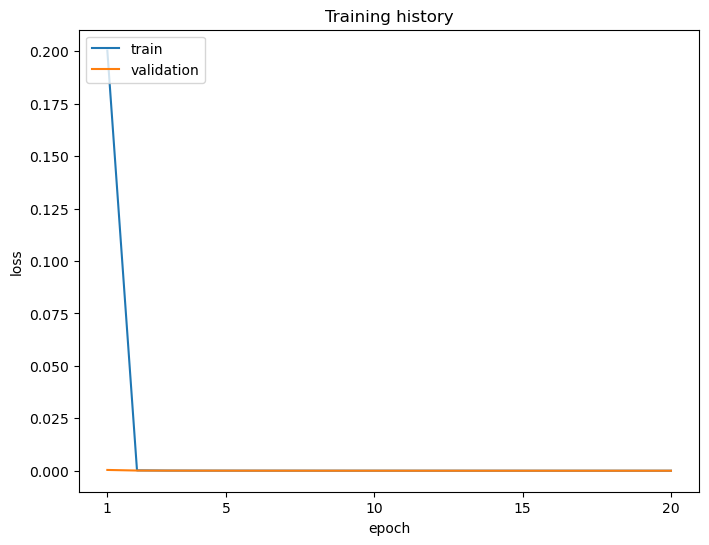

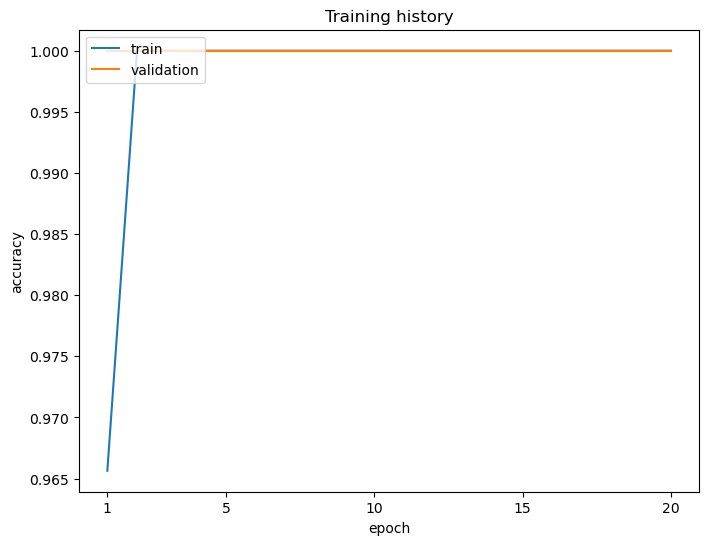

In [16]:
plot_history(history)

## Evaluate on Test Data

In [17]:
model = tf.keras.models.load_model(os.path.join(base_dir, "Models/IMDB_model1/IMDB_model1_01-1.0000.keras"))

In [18]:
pred = model.predict(test_data)

339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [19]:
test_y = np.concatenate([labels for _, labels in test_data], axis=0)

2024-12-18 20:00:20.627908: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
evaluate_classification_result(test_y, pred, classes=test_data_raw.class_names)

Confusion matrix (rows -> true, columns -> predicted):

       neg  pos
neg  11902    0
pos   9756    0


Class neg:
    Sensitivity (TPR): 100.000% (11902 of 11902)
    Specificity (TNR):   0.000% (0 of 9756)
    Precision:          54.954% (11902 of 21658)
    Neg. pred. value:      nan% (0 of 0)
Class pos:
    Sensitivity (TPR):   0.000% (0 of 9756)
    Specificity (TNR): 100.000% (11902 of 11902)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   54.954% (11902 of 21658)

Overall accuracy:   54.954% (11902 of 21658)
Balanced accuracy:  50.000%


/opt/conda/lib/python3.11/site-packages/pyMLaux/functions.py:171: RuntimeWarning: invalid value encountered in scalar divide
  print('    Neg. pred. value:  %7.3f%% (%d of %d)'%(100. * tn / (tn + fn) , tn, tn + fn))
/opt/conda/lib/python3.11/site-packages/pyMLaux/functions.py:166: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)


## Evaluate on Custom Test Data

In [21]:
my_text = ['this is probably the worst movie i have seen in my entire life it really sucks in the most obnoxious way',
           'if i had a dollar for each error in this movie i would be rich',
           'great movie wow i really really liked it',
           'complete trash show wasted money if you ask me',
           'this was one of the worst movies i have ever seen',
           'great movie would highly recommend',
           'it was an incredible experience and i would watch it again without second thought',
           'film bad',
           'it was more or less good']

In [22]:
my_test_data =  np.array([vectorize_layer(text) for text in my_text])
my_test_data

array([[   9,    7,  222, ...,    0,    0,    0],
       [  41,   11,   59, ...,    0,    0,    0],
       [ 140,   14, 1142, ...,    0,    0,    0],
       ...,
       [  10,   13,   38, ...,    0,    0,    0],
       [  19,   47,    0, ...,    0,    0,    0],
       [  10,   13,   53, ...,    0,    0,    0]])

In [23]:
pred = model.predict(my_test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [24]:
pd.DataFrame({'review': my_text, 'pred': pred.reshape(-1)})

,review,pred
0,this is probably the worst movie i have seen i...,0.000345
1,if i had a dollar for each error in this movie...,0.000345
2,great movie wow i really really liked it,0.000345
3,complete trash show wasted money if you ask me,0.000345
4,this was one of the worst movies i have ever seen,0.000345
5,great movie would highly recommend,0.000345
6,it was an incredible experience and i would wa...,0.000345
7,film bad,0.000345
8,it was more or less good,0.000345


In [25]:
!cd $notebook_dir; jupyter nbconvert --to html LSTM_IMDB.ipynb

[NbConvertApp] WARNING | pattern 'LSTM_IMDB.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    E